# A simple example on how to use `scopes`

In this tutorial you will learn the basic functionality of SCOPES and how to set everything up to use it.

## Topics

- Construct the "Night" object to designate the specific night of the year for which the schedule is to be created.
- Establish the observing programs, outlining their specific objectives and parameters.
- Determine the merits to be utilized, ensuring they align with the objectives of the observing programs.
- Create the "Target" objects, assigning appropriate merits based on the unique requirements of each target.
- Create the "Observation" objects which are the objects to create the Schedule.
- Test the scheduler by creating a simple and short schedule of just 3 observations to see how it works.
- Create a more extended sample of Targets to create a simulation of a full night of observations.

### Imports

In [1]:
from scopes.scheduler_components import (
    Night,
    Program,
    Merit,
    Target,
    Observation,
    Overheads,
)
from scopes import merits
from scopes import scheduler

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from datetime import date, timedelta
from astropy.coordinates import SkyCoord
import astroplan

### Observer and Night

We will start by defining the Observer, that is where in the world our telescope is located, and for which night we want to create a schedule. This is done using the Observer object from the `astroplan` package. For this example we will consider a telescope at the La Silla Observatory in Chile.

We then create the Night object for which night we want to create the schedule. This is done by defining the date and within which twilights observations should be considered.

NOTE: The `night_date` refers to the date when the night starts at the telescope's location, according to local time. This is important as, depending on the time zone, the UTC date might differ. For instance, if a night in Chile begins at 21:15 hs local time on November 14, 2024, the `night_date` is considered to be November 14, 2024 (even though in UTC this time and date corresponds to 00:15hs on Novemeber 15, 2025).

In [2]:
# Define observer location
observer = astroplan.Observer.at_site("La Silla Observatory")

# Define the night
night = Night(date(2023, 11, 14), "nautical", observer)

### Programs

SCOPES allows to define different observing programs. This is widely the case in many telescopes where different groups use the telescope for different purposes and thus each group or person has their own observing program with their own set of targets and scientific priorities.

These are defined with the `Program` object where the parameters to be given are the program ID, name of the instrument to be used, the proprotion of the total time that is allocated to this program, and optionally with what color this program will be plotted.

In [3]:
# Define color pallette for plotting
color_pallette = iter([mcolors.rgb2hex(color) for color in plt.get_cmap("Set2").colors])

# The parameters are:
# 1. Name of the program
# 2. Name of the instrument
# 3. Priority of the program
# 4. Time share allocated to the program
# 5. (optional) Plot color
# Lets use "GUITAR" and "PIANO" as our two example instruments
prog1 = Program("prog1", "GUITAR", 1, 0.1, plot_color=next(color_pallette))
prog2 = Program("prog2", "GUITAR", 2, 0.1, plot_color=next(color_pallette))
prog3 = Program("prog3", "GUITAR", 2, 0.3, plot_color=next(color_pallette))
prog4 = Program("prog4", "PIANO", 3, 0.2, plot_color=next(color_pallette))
prog5 = Program("prog5", "PIANO", 2, 0.3, plot_color=next(color_pallette))

Now we will tell SCOPES how much time each of these programs have taken up already. This is done by calling the `set_current_time_usage()` method on each program and indicating the current time used by that program (as a percentage of the total time).

To simulate a somewhat real situation, lets asume that prog1 and prog3 were observed less than was allocated to them, prog4 is close to even, while prog2 and prog5 were observed more than the time they were allocated.

In [4]:
prog1.set_current_time_usage(0.15)
# prog2.set_current_time_usage(0.13)
prog3.set_current_time_usage(0.35)
prog4.set_current_time_usage(0.10)
# prog5.set_current_time_usage(0.39)

## Merits

Now we will define the set of merits we will be using. Some standard merit functions can be found in the `scopes.merits` module, but custom ones can be defined as well.

The Merit class takes three mandatory arguments, `name`, `func`, and `merit_type`. `func` is the function that actually computes the merit from an observation, `merit_type` tells the scheduler how to use the merit in the rank function, i.e. if its a fariness, veto, or efficiency merit. Then the optional `paramteres` arguments gives the function any additional keyword arguments for that merit. This allows to create merits that use the same merit function but with a different set of parameters.

In [5]:
# We will start with the basic observability merits like limits on the airmass, altitude, and time of night.

# Lets define a merit for the airmass setting a maximum of 1.8
airmass_merit_18 = Merit(
    "Airmass", merits.airmass, merit_type="veto", parameters={"limit": 1.8}
)

# Lets define a merit for the airmass setting a maximum of 1.5
airmass_merit_15 = Merit(
    "Airmass", merits.airmass, merit_type="veto", parameters={"limit": 1.5}
)

# Lets define a merit for the altitude. These are usually set by the hardware limits of the telescope.
# In this exmaple we will use a minimum of 20 and a maximum of 87 degrees (to avoid the zenith
# which can cause tracking issues in telescopes with an altazimuth mount)
altitude_merit = Merit(
    "Altitude", merits.altitude, merit_type="veto", parameters={"min": 20, "max": 87}
)

# Lets define a merit for the time of night. These limits are used from the Night object we created above.
at_night_merit = Merit("AtNight", merits.at_night, merit_type="veto")

# Now we will define a merit for the moon separation. This merit will ensure that the moon is at least
# 30 degrees away from the target.
moon_sep_merit = Merit(
    "MoonSep",
    merits.moon_separation,
    merit_type="veto",
    parameters={"theta_lim": 20, "theta_start": 30, "alpha": 3},
)

# The Culmination merit is used to ensure observations are done close to the culmination of the target in the sky.
culmapping_merit = Merit(
    "CulMapping", merits.culmination_efficiency, merit_type="efficiency"
)

# Lastly, we will deifne a fairness merit for the time share. This merit ensures that programs
# respect the time share they are given.
timeshare_merit = Merit("Timeshare", merits.time_share, merit_type="fairness")
priority_merit = Merit("Priority", merits.priority, merit_type="fairness")

Lets define two sets of merits to use later

In [6]:
merits1 = [
    airmass_merit_18,
    altitude_merit,
    at_night_merit,
    # moon_sep_merit,
    culmapping_merit,
    timeshare_merit,
    priority_merit,
]

merits2 = [
    airmass_merit_15,
    altitude_merit,
    at_night_merit,
    # moon_sep_merit,
    culmapping_merit,
    timeshare_merit,
    priority_merit,
]

### Set up the Overheads object

The `Overheads` defines all the overheads that your telescope has when transitioning from one observation to the next. The basic overhead common to all telescopes is the slew time that the telescope takes to move from one position in the sky to the next. 

Then custom overheads can be defined and added to the object. Here any type of overhead can be defined using the properties of the Observations, Targets, Instruments, etc. For the overhead function to be valid is has to have two parameters called `observation1` and `observation2`, where the transition time will be from `observation1` to `observation2`.

When you add your custom overhead function to the Overhead object you can indicate if this overhead time can overlap with the slew time. Meaning if it happens in parallel as the telescope is moving from one position to the next.

If more than one custom overhead is added they are assumed to happen in sequence.

NOTE: This could be improved as the overhead calculation might be complicated. Ideas are welcome.

In [7]:
# We start by initializing the Overheads object with the slew rates of the telescope.
# In this example we will use a slew rate of 2 degrees per second in both axes.
overheads = Overheads(slew_rate_az=1, slew_rate_alt=2)


# We will now define a custom overhead related to the change of instrumnet.
# The overhead function has to take two observations (observation1 and observation2) as input
# and return the overhead time in seconds.
def change_instrument_overhead(observation1: Observation, observation2: Observation):
    if observation1.target.program.instrument != observation2.target.program.instrument:
        # In this telescope it takes 170 seconds to change the instrument in either direction
        # You can define a more complex function here if you want to have different overheads
        # For example if the change from a camera to a spectrograph might take longer or viceversa
        return 150
    else:
        return 0


# We add this overhead to the Overheads object
overheads.add_overhead(change_instrument_overhead, can_overlap_with_slew=True)

## Targets and Observations

Next we will define the targets to be observed by creating Target objects and then Observation Objects.

The `Target` object contain information about the target itself, like its name, coordinates, which program it is part of, its priority and most importantly its individual merit functions which determine how the target should be observed.

The `Observation` object takes a target as input and adds the exposure time. The reason the Target and Observation objects are distinct is to allow the posisblity to create more than one observation for the same target if needed.

**In this tutorial we will create simulated targets, but in this section is where one would actually load the actual targets that want to be observed.**

### Simple case

Let's start with just 3 targets to see how SCOPES puts the obesrvations together into a schedule.

In [8]:
# We are going to use a start time of just less than the middle of the night
(night.night_time_range[0].jd + night.night_time_range[-1].jd) / 2

2460263.6855988586

In [9]:
# We create the Target object with the name, program, coordinates, and priority
star1 = Target("Star1", prog1, SkyCoord(45, -50, unit="deg"), priority=1)
# We add the merits we want to the target, in this case we are using the merits1 list we defined above
star1.add_merits(merits1)
star2 = Target("Star2", prog1, SkyCoord(52, -50, unit="deg"), priority=1)
star2.add_merits(merits1)
star3 = Target("Star3", prog1, SkyCoord(60, -50, unit="deg"), priority=1)
star3.add_merits(merits1)

# We define an exposure time for the observations
# In this case we will use 1800 seconds (30 minutes)
exp_time1 = 1800
obs1 = Observation(star1, exp_time1)
obs2 = Observation(star2, exp_time1)
obs3 = Observation(star3, exp_time1)
test_obs = [obs1, obs2, obs3]

In [10]:
# Initialize the scheduler
gQ_scheduler = scheduler.generateQ(
    night, test_obs, overheads, plan_start_time=2460263.66
)

Preparing observations for scheduling...


  0%|          | 0/3 [00:00<?, ?it/s]

NOTE: Implement end of plan as a precise time

In [11]:
# Run the scheduler and create the plan
test_plan = gQ_scheduler.run(max_plan_length=None, K=2)

Creating the Plan...
Done!


In [12]:
test_plan.print_stats()

Length = 3
Score = 0.855025
Evaluation = 0.967007
Observation time = 1:30:00
Overhead time = 0:00:27.124938
Observation ratio = 0.99500
Overhead ratio = 0.00500
Avg airmass = 1.07028


In [13]:
print(test_plan)

#     ProgID  Instrument  Target  RA        DEC        Start Time  (Exp Time)  Comment for the observer  
 1:   prog1   GUITAR      Star1   03:00:00  -50:00:00  03:50:24    (0:30:00)                             
 2:   prog1   GUITAR      Star2   03:28:00  -50:00:00  04:20:36    (0:30:00)                             
 3:   prog1   GUITAR      Star3   04:00:00  -50:00:00  04:50:51    (0:30:00)                             


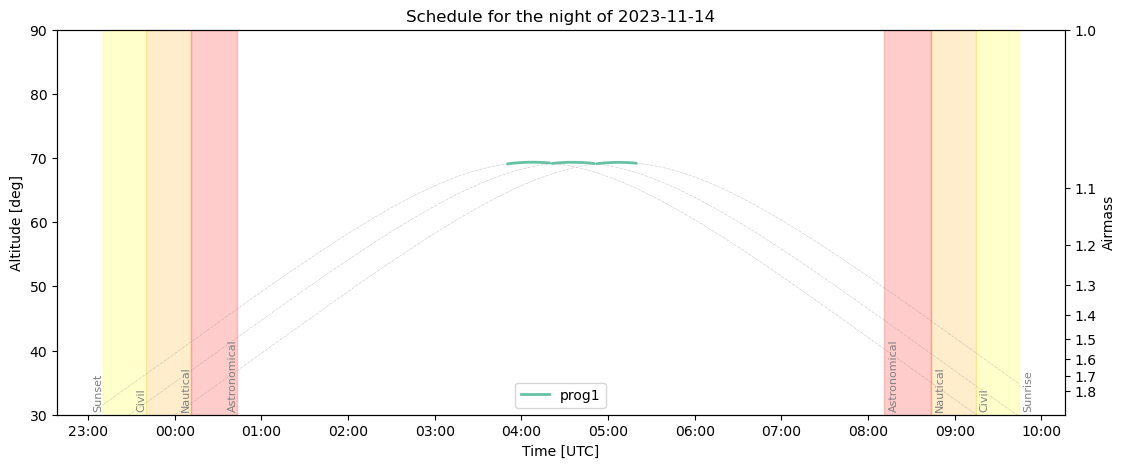

In [14]:
test_plan.plot()

We see that the scheduler has put the observations in the correct order to maximise the airmass of each.

### Full night schedule

Now let's create a full night schedule with stars from all programs and instruments

In [15]:
# Generate random star coordinates
np.random.seed(1)
ntars = 100

# Right ascension angle range that is visible from La Silla on the night of 2023-11-14 is roughly
# between 0 and 160, and 300 to 360 degrees
ra = np.random.uniform(300, 520, size=ntars) % 360
dec = -np.rad2deg(np.arcsin(np.random.uniform(0, 1, size=ntars)))

# We will initialize the observations start time at the start of the night
start_time = night.night_time_range[0].jd


# Create Observations objects
def create_tars_and_obs(prog, idx_range, merits):
    observations = []
    for i in range(idx_range[0], idx_range[1]):
        # Get the coordinates for the target
        coord = SkyCoord(ra[i], dec[i], unit="deg")
        # Create the Target object with a random priority
        target = Target(f"Target{i}", prog, coord, np.random.randint(0, 4))
        # Add the merits to the target
        target.add_merits(merits)

        # Create the observation

        exposure_time = np.random.randint(300, 1200)
        # exposure_time = 900  # seconds
        observation = Observation(target, exposure_time)
        observations.append(observation)
    return observations

Now lets create the Observations for each program. Let's assume that prog1 and prog2 need their targets to be observed at a maximum airmass of 1.5 as they need a good SNR. In contrast, prog3, prog4, and prog5 are not that sensitive to SNR and allows their targets to be observed up to an airmass of 1.8.

In [16]:
obs_prog1 = create_tars_and_obs(prog1, (0, 20), merits1)
obs_prog2 = create_tars_and_obs(prog2, (20, 40), merits1)
obs_prog3 = create_tars_and_obs(prog3, (40, 60), merits2)
obs_prog4 = create_tars_and_obs(prog4, (60, 80), merits1)
obs_prog5 = create_tars_and_obs(prog5, (80, 100), merits2)

all_obs = obs_prog1 + obs_prog2 + obs_prog3 + obs_prog4 + obs_prog5

## Scheduling the night

We have set up everything we need to now create the night sschedule based on the observations we created.

To do this we will initialize a Scheduler object from the `scopes.scheudler` module. To start we will use the simple generateQ scheduler which works based on a simple greedy search algorithms which works sequentially from the beginning of the night and always chooses the best scoring observation as the next observation to do.

In [17]:
# Initialize the scheduler
# Leaving the plan_start_time as None will set it to the start of the observable night
gQ_scheduler = scheduler.generateQ(night, all_obs, overheads)

Preparing observations for scheduling...


  0%|          | 0/100 [00:00<?, ?it/s]

In [18]:
# Run the scheduler and create the plan
plan = gQ_scheduler.run(K=3)

Creating the Plan...
Done!


In [19]:
plan.print_stats()

Length = 34
Score = 1.085665
Evaluation = 0.923366
Observation time = 7:31:58
Overhead time = 1:00:00.473333
Observation ratio = 0.88279
Overhead ratio = 0.11721
Avg airmass = 1.19331


In [20]:
print(plan)

#     ProgID  Instrument  Target    RA        DEC        Start Time  (Exp Time)  Comment for the observer  
 1:   prog1   GUITAR      Target2   20:00:06  -62:22:04  00:11:01    (0:18:41)                             
 2:   prog2   GUITAR      Target27  20:34:22  -57:21:19  00:29:46    (0:15:43)                             
 3:   prog1   GUITAR      Target6   22:43:55  -00:54:24  00:47:27    (0:07:30)                             
 4:   prog1   GUITAR      Target5   21:21:15  -38:33:43  00:56:23    (0:14:16)                             
 5:   prog1   GUITAR      Target19  22:54:20  -07:08:19  01:11:57    (0:15:01)                             
 6:   prog3   GUITAR      Target57  22:09:07  -35:32:46  01:28:03    (0:07:48)                             
 7:   prog1   GUITAR      Target18  22:03:32  -45:21:33  01:36:09    (0:14:45)                             
 8:   prog1   GUITAR      Target3   00:26:03  -20:55:57  01:52:36    (0:13:25)                             
 9:   prog1   GUITAR      Ta

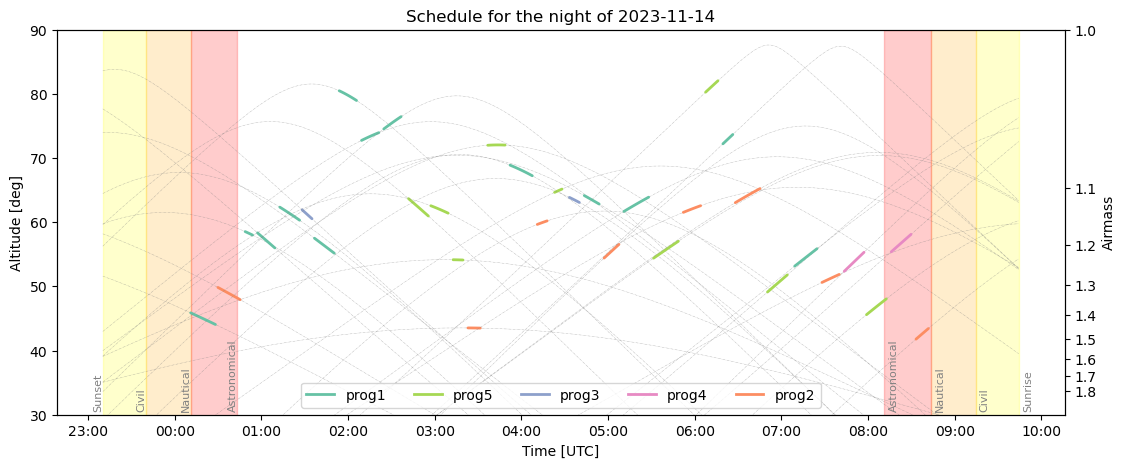

In [21]:
plan.plot()

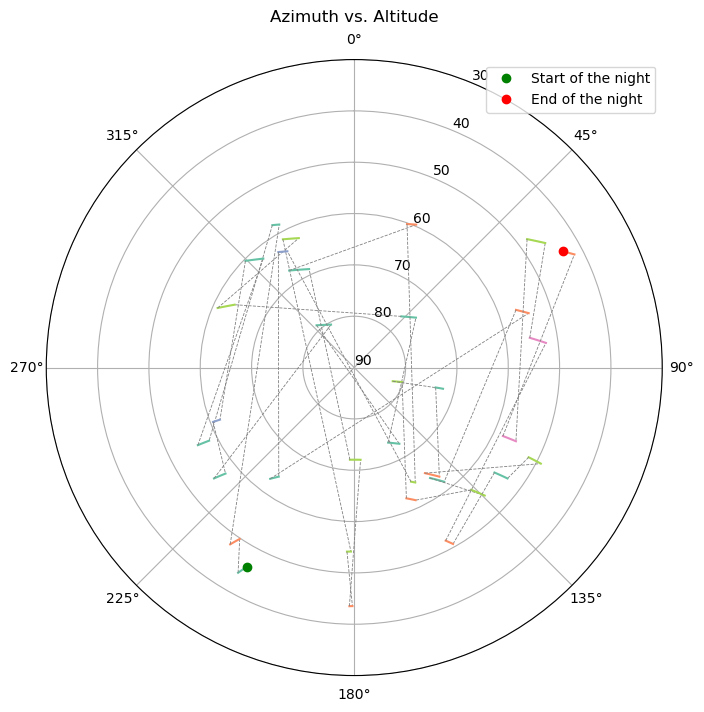

In [22]:
plan.plot_polar()

### Optimization

In [25]:
lsh_move_plan = gQ_scheduler.lsh_optimization_move(plan, iterations=2, verbose=True)

Initial plan overhead time: 1:00:00.473333

Optimized plan overhead time: 0:40:23.790277
Total time saved in iteration 1 with 17 moves: 0:19:36.683056


Optimized plan overhead time: 0:40:16.339100
Total time saved in iteration 2 with 3 moves: 0:00:07.451177

Total time saved:  0:19:44.134233


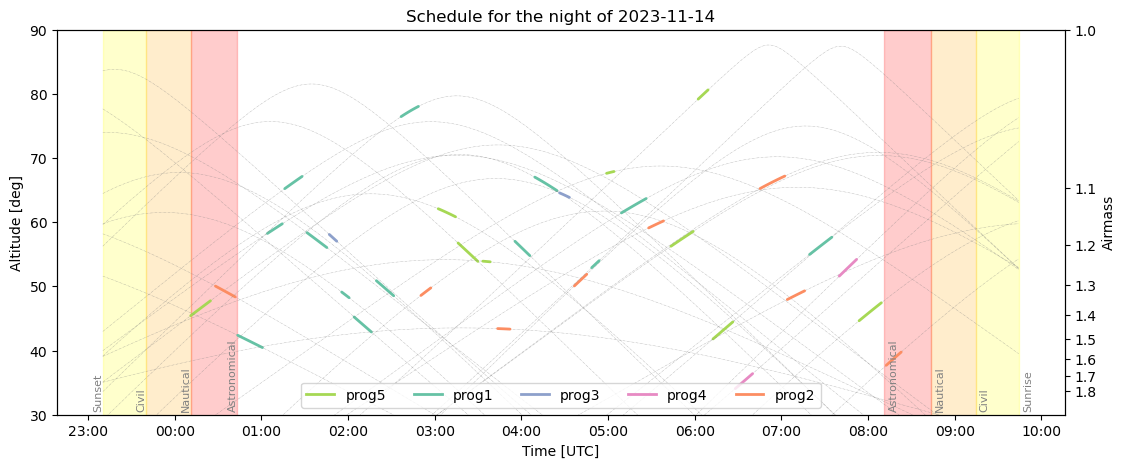

In [26]:
lsh_move_plan.plot()

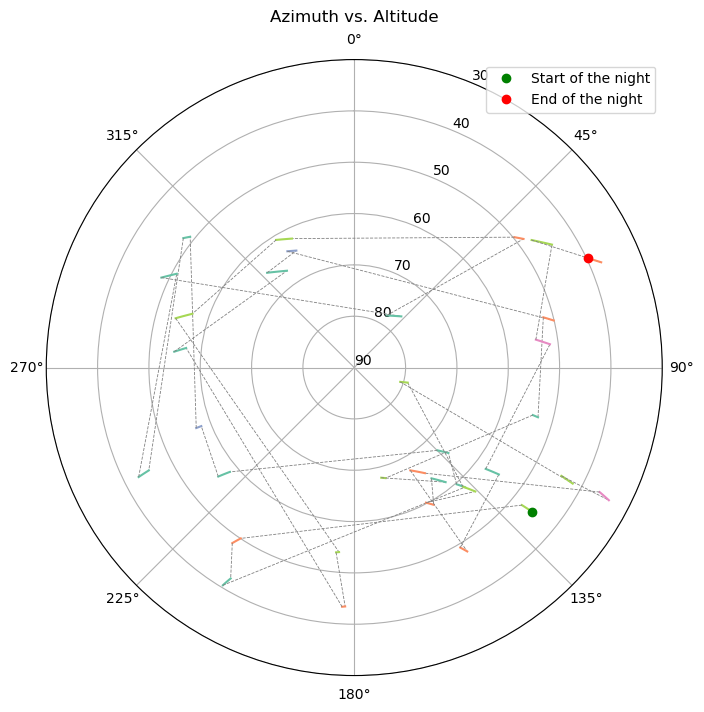

In [27]:
lsh_move_plan.plot_polar()

In [31]:
lsh_swap_plan = gQ_scheduler.lsh_optimization_swap(plan, iterations=None, verbose=True)

Initial plan overhead time: 1:00:00.473333

Optimized plan overhead time: 0:38:16.374754
Total time saved in iteration 1 with 13 moves: 0:21:44.098579


Optimized plan overhead time: 0:29:00.857389
Total time saved in iteration 2 with 15 moves: 0:09:15.517365


Optimized plan overhead time: 0:27:38.713638
Total time saved in iteration 3 with 4 moves: 0:01:22.143751


Optimized plan overhead time: 0:27:24.605245
Total time saved in iteration 4 with 2 moves: 0:00:14.108393


Optimized plan overhead time: 0:27:24.605245
Total time saved in iteration 5 with 0 moves: 0:00:00

Total time saved:  0:32:35.868088


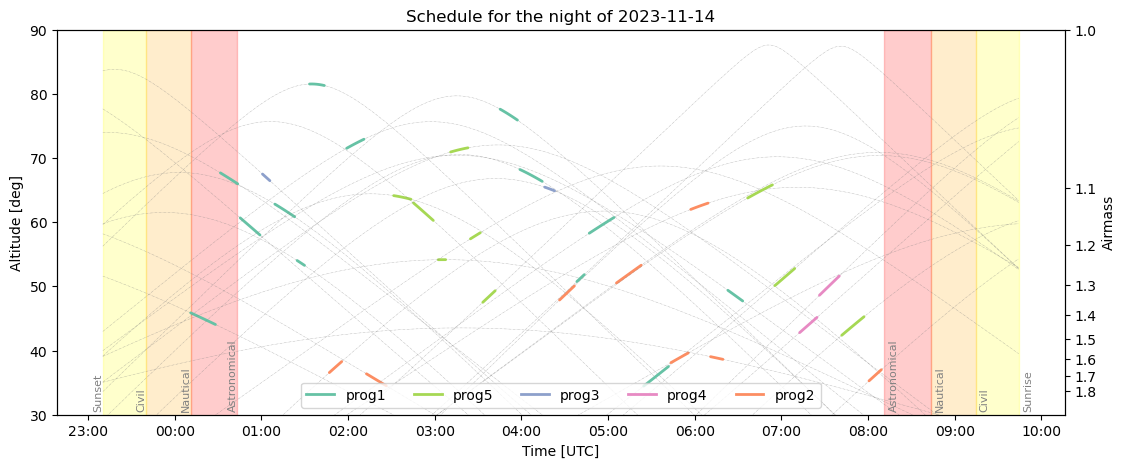

In [32]:
lsh_swap_plan.plot()

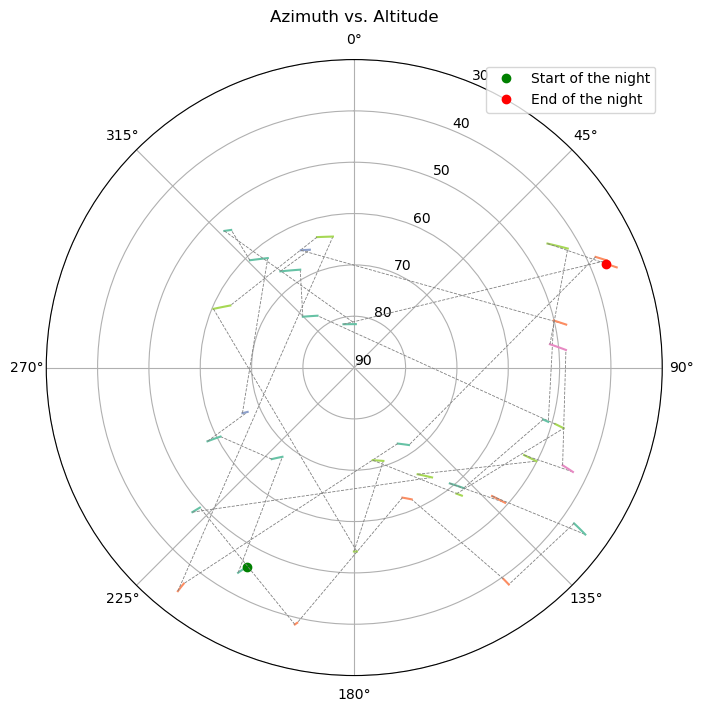

In [33]:
lsh_swap_plan.plot_polar()

In [29]:
new_plan = gQ_scheduler.optimize_plan(plan, iterations=None)

Initial plan score: 0.9321
Optimized plan score: 0.9343 (after 2 iterations)


In [28]:
new_plan.print_stats()

Length = 37
Score = 0.917196
Evaluation = 0.878479
Observation time = 7:25:09
Overhead time = 1:07:13.399777
Observation ratio = 0.86880
Overhead ratio = 0.13120
Avg airmass = 1.21778


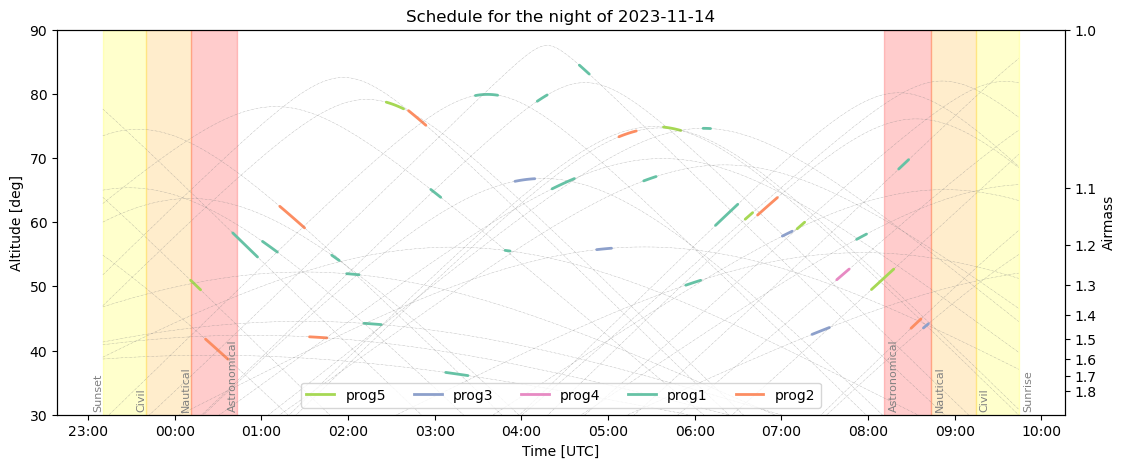

In [29]:
new_plan.plot()

In [30]:
nnew_plan = gQ_scheduler.plan_deepcopy(new_plan)
# nnew_plan = gQ_scheduler.swap_observations(nnew_plan, 0, 1)
nnew_plan = gQ_scheduler.swap_observations(nnew_plan, 4, 5)
nnew_plan = gQ_scheduler.move_observation(nnew_plan, 7, 5)
nnew_plan = gQ_scheduler.move_observation(nnew_plan, 11, 9)
nnew_plan = gQ_scheduler.move_observation(nnew_plan, 13, 10)
nnew_plan = gQ_scheduler.move_observation(nnew_plan, 11, 6)
nnew_plan = gQ_scheduler.move_observation(nnew_plan, 12, 7)
nnew_plan = gQ_scheduler.move_observation(nnew_plan, 33, 34)
nnew_plan = gQ_scheduler.move_observation(nnew_plan, 23, 31)
nnew_plan = gQ_scheduler.move_observation(nnew_plan, 20, 15)
nnew_plan = gQ_scheduler.move_observation(nnew_plan, 28, 29)

In [31]:
print("These few permutation save a total overhead time of:")
print(new_plan.overhead_time - nnew_plan.overhead_time)

These few permutation save a total overhead time of:
0:06:07.918060


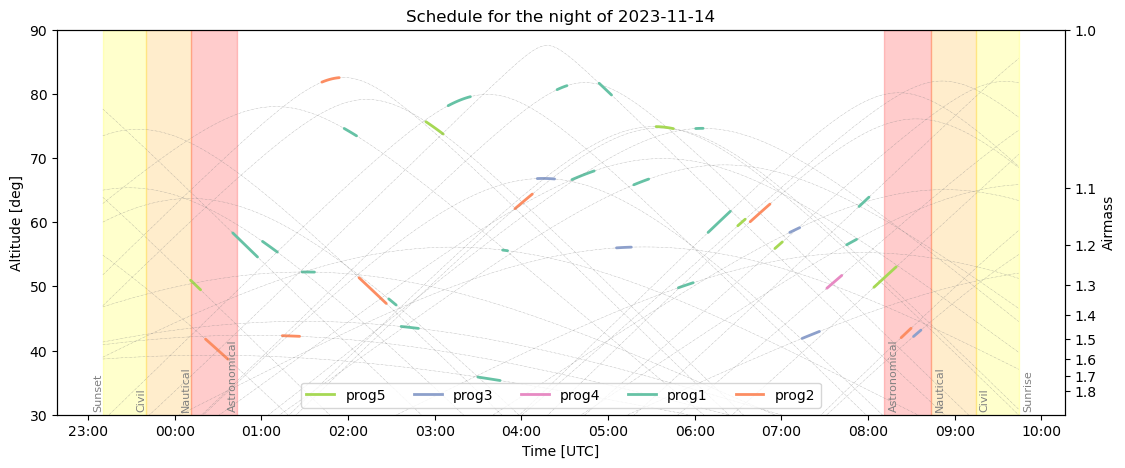

In [32]:
nnew_plan.plot()

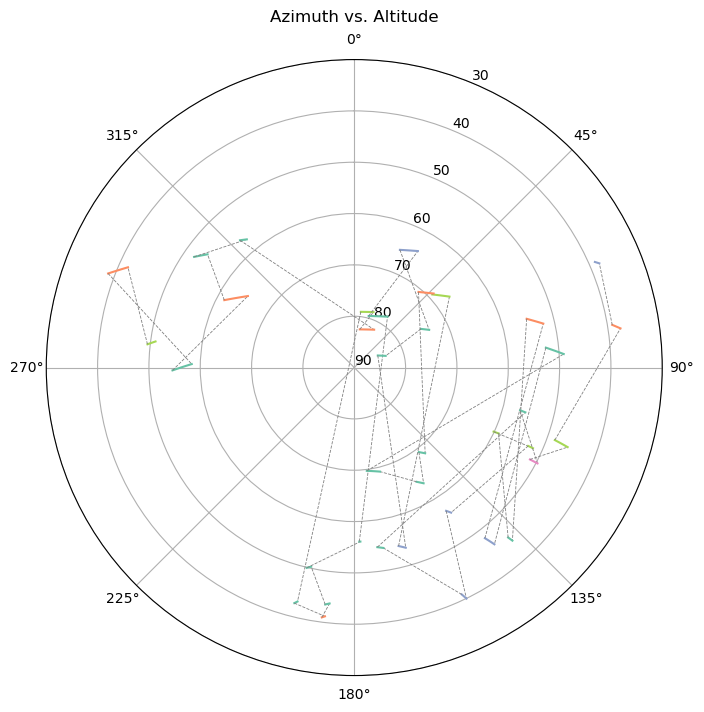

In [29]:
nnew_plan.plot_polar()

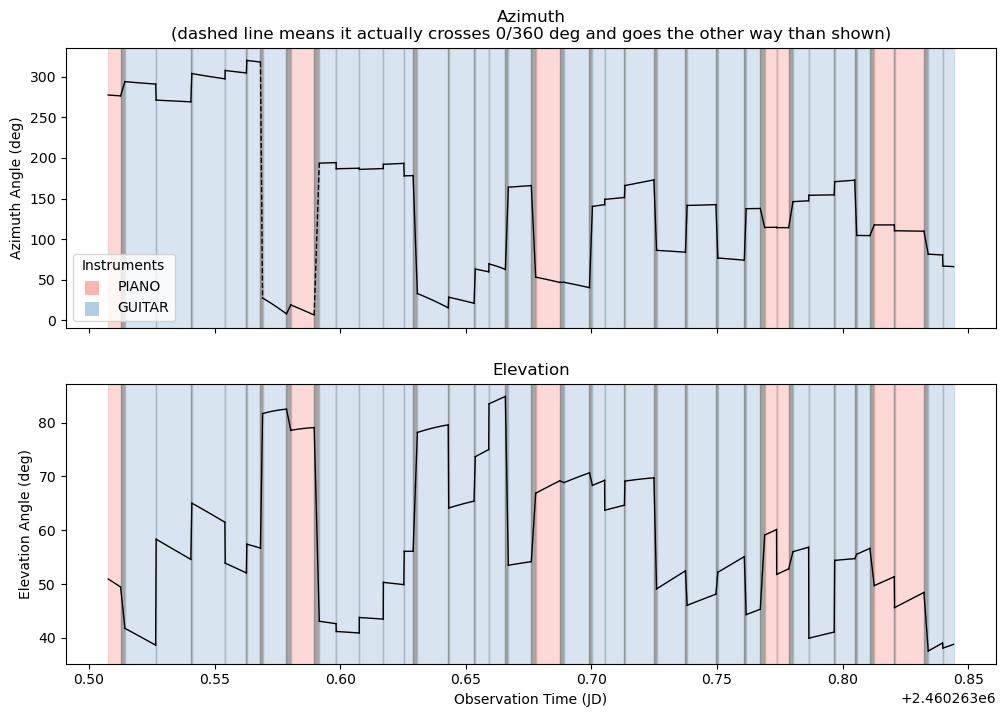

In [61]:
nnew_plan.plot_altaz()

### Scheduling only a part of the night

Let's say that we only want to schedule a part of the night. In that case we can add start and end times for the schedule and it will only schedule observations between the two selected times.

These variables (`plan_start_time` and `plan_end_time`) are optional and their default values are the start and end of the observable night respectively. So you can also only indicate a start time and schedule until the end of the night, or inversly, ony indicate and end time in which case it will schedule fromthe beginning of the night until the indicated time.

In [42]:
night.obs_within_limits

array([2460263.50765796, 2460263.86353976])

In [43]:
# Initialize the scheduler
# Leaving the plan_start_time as None will set it to the start of the observable night
gQ_scheduler = scheduler.generateQ(
    night, all_obs, overheads, plan_start_time=2460263.6, plan_end_time=2460263.75
)

Preparing observations for scheduling...


  0%|          | 0/100 [00:00<?, ?it/s]

In [44]:
# Run the scheduler and create the plan
subplan = gQ_scheduler.run(K=5)

Creating the Plan...
Done!


In [45]:
subplan.print_stats()

Length = 15
Score = 1.053614
Evaluation = 0.969766
Observation time = 3:17:33
Overhead time = 0:17:04.835400
Observation ratio = 0.92042
Overhead ratio = 0.07958


In [46]:
print(subplan)

#     ProgID  Instrument  Target    RA        DEC        Start Time  (Exp Time)  Comment for the observer  
 1:   prog2   GUITAR      Target24  00:48:15  -21:56:42  02:24:00    (0:13:42)                             
 2:   prog5   PIANO       Target83  01:04:30  -18:31:26  02:39:21    (0:13:23)                             
 3:   prog1   GUITAR      Target0   23:15:21  -80:06:33  02:54:24    (0:17:18)                             
 4:   prog4   PIANO       Target66  01:17:43  -29:46:54  03:13:22    (0:16:13)                             
 5:   prog1   GUITAR      Target15  00:01:12  -41:21:51  03:31:15    (0:09:28)                             
 6:   prog5   PIANO       Target85  01:37:24  -36:57:58  03:42:23    (0:09:49)                             
 7:   prog5   PIANO       Target99  02:02:01  -04:05:12  03:53:02    (0:19:45)                             
 8:   prog1   GUITAR      Target12  02:28:21  -19:17:03  04:14:27    (0:17:41)                             
 9:   prog1   GUITAR      Ta

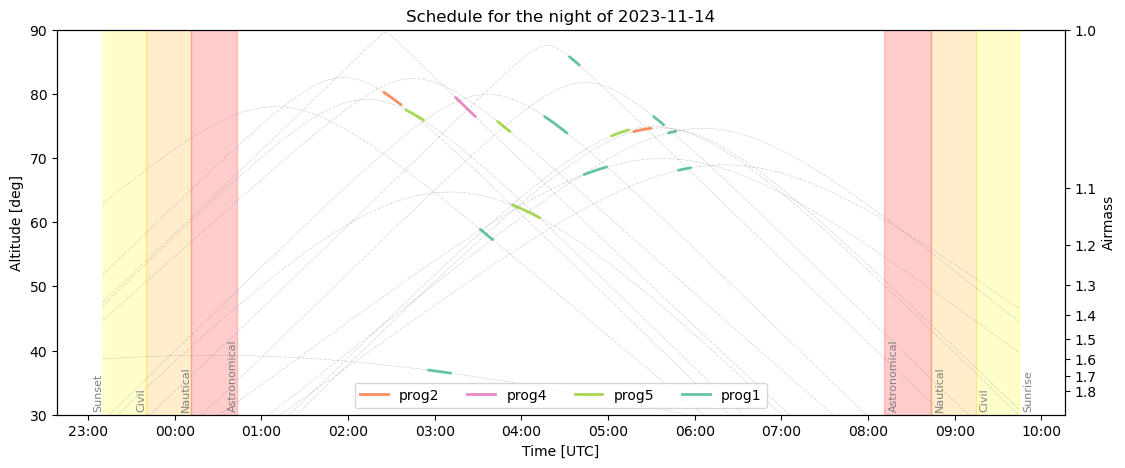

In [47]:
subplan.plot()

In [48]:
new_subplan = gQ_scheduler.optimize_plan(subplan, iterations=None)

Initial plan score: 1.0062802856886248
Optimized plan score: 1.015517141198887 (after 3 iterations)


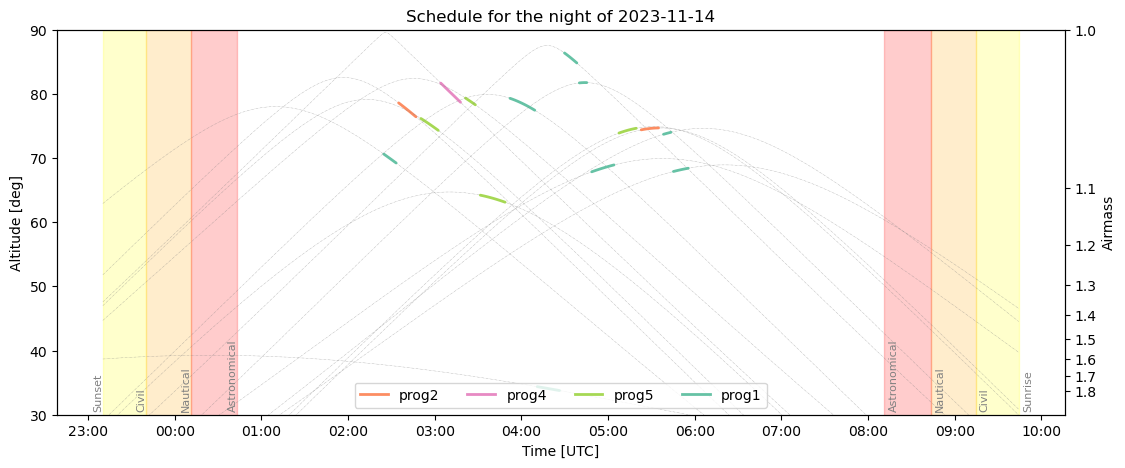

In [49]:
new_subplan.plot()

## Test different schedulers

Let's try some other type of scheduling algorithms. These can be created customly by creating a new class that inherits from the base `Scheduler` class and includes a `run()` method that creates a Plan from the provided list of observations.

Here we will test the Dynamic Programming Planner (`DPPlanner`) and the `BeamSearchPlanner` schedulers.

### Dynamic Programming Planner (`DPPlanner`)

In [21]:
# Initialize the scheduler
# Leaving the plan_start_time as None will set it to the start of the observable night
dp_scheduler = scheduler.DPPlanner(night, all_obs, overheads)

Preparing observations for scheduling...


  0%|          | 0/100 [00:00<?, ?it/s]

In [22]:
# Reset the DP scheduler by clearing the cache (only needed when re-running the scheduler)
dp_scheduler.reset_dp()
# Run the scheduler and create the plan
plan_dp = dp_scheduler.run(max_plan_length=10, K=2)

In [23]:
plan_dp.print_stats()

Length = 10
Score = 1.064747
Evaluation = 1.018993
Observation time = 2:36:14
Overhead time = 0:07:00.904667
Observation ratio = 0.95703
Overhead ratio = 0.04297


In [24]:
print(plan_dp)

Plan for the night of 2023-11-14 (Times in UTC)
--------------------------------------------------

#     Program ID     Target              Start time   (Exp time)  Comment for the observer                
 1:   prog1 GUITAR   Target16            00:11:01     (0:19:19)                                           
 2:   prog5 PIANO    Target87            00:32:00     (0:19:45)                                           
 3:   prog5 PIANO    Target92            00:52:12     (0:06:52)                                           
 4:   prog4 PIANO    Target67            00:59:15     (0:12:53)                                           
 5:   prog4 PIANO    Target63            01:12:43     (0:19:07)                                           
 6:   prog3 GUITAR   Target48            01:33:30     (0:18:06)                                           
 7:   prog1 GUITAR   Target9             01:51:49     (0:19:56)                                           
 8:   prog4 PIANO    Target76            02:

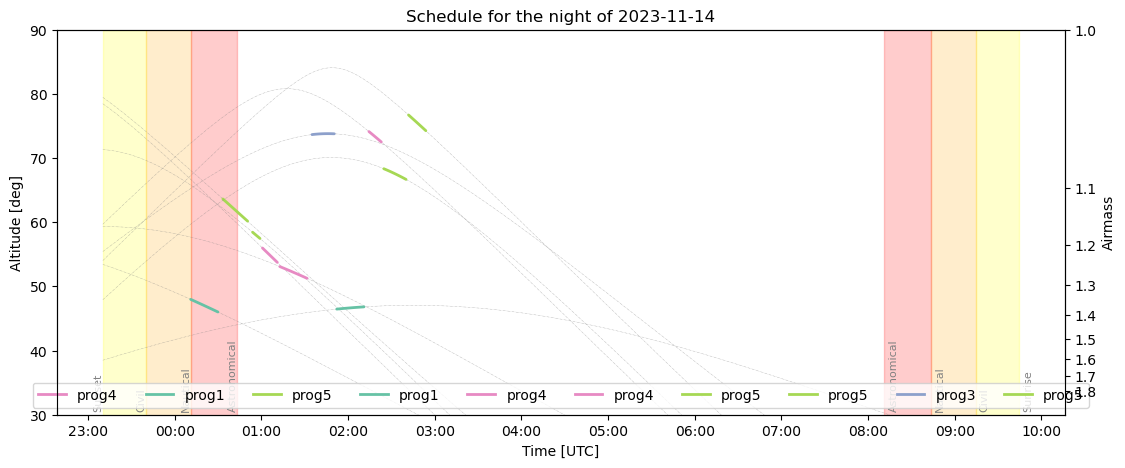

In [25]:
plan_dp.plot()

### Beam Search Planner (`BeamSearchPlanner`)

The BeamSearchPlanner algorithm can be visualized as navigating a decision tree where each node represents a potential observation plan, and each branch signifies adding an observation. Starting from the root (an empty plan), the algorithm explores various branches, but instead of examining every possible path, it employs a "beam" strategy to keep only the top K most promising branches at each level, effectively pruning the rest. This selective exploration ensures that the tree does not grow too large and unwieldy, focusing computational resources on extending only the most promising plans. As the algorithm progresses down the tree, it continuously evaluates and updates the best plan based on a scoring system, until it either reaches the maximum plan length or no further promising branches exist, culminating in the most optimal schedule of observations within the given constraints.

In [26]:
# Initialize the scheduler
# Leaving the plan_start_time as None will set it to the start of the observable night
bs_scheduler = scheduler.BeamSearchPlanner(night, all_obs, overheads)

Preparing observations for scheduling...


  0%|          | 0/100 [00:00<?, ?it/s]

In [27]:
# Run the scheduler and create the plan
bs_plan = bs_scheduler.run(max_plan_length=10, K=5)

In [28]:
bs_plan.print_stats()

Length = 10
Score = 1.068260
Evaluation = 1.034635
Observation time = 2:22:26
Overhead time = 0:04:37.738742
Observation ratio = 0.96852
Overhead ratio = 0.03148


In [29]:
print(bs_plan)

Plan for the night of 2023-11-14 (Times in UTC)
--------------------------------------------------

#     Program ID     Target              Start time   (Exp time)  Comment for the observer                
 1:   prog1 GUITAR   Target16            00:11:01     (0:19:19)                                           
 2:   prog2 GUITAR   Target34            00:30:40     (0:13:37)                                           
 3:   prog2 GUITAR   Target26            00:44:52     (0:09:41)                                           
 4:   prog5 PIANO    Target87            00:56:13     (0:19:45)                                           
 5:   prog5 PIANO    Target92            01:16:21     (0:06:52)                                           
 6:   prog4 PIANO    Target67            01:23:23     (0:12:53)                                           
 7:   prog5 PIANO    Target95            01:36:26     (0:19:19)                                           
 8:   prog4 PIANO    Target63            01:

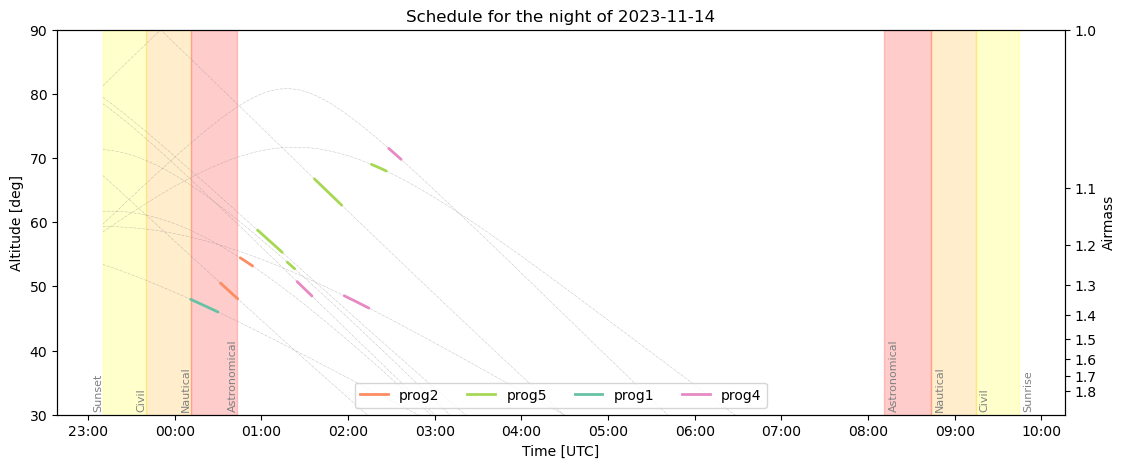

In [30]:
bs_plan.plot()